# Machine Learning Methods Applied to FX Portfolio Risk Management - Andrew Villacis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import *
from sklearn.tree import *
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, GroupKFold, TimeSeriesSplit, RandomizedSearchCV
import capstone_proj as cp

filepath = "/Users/andresvillacis/Documents/GitHub/capstone_proj/Data/FX_Test_USD-per-FX_Chicago.csv"
# Testing to be between 2003 and 2012, with indicators running back up to 2002. Testing will be 2014 forward in year or randomized intervals

## Decision Trees

## Classification

I will try to predict whether the next day a currency will go up or down. I am going to use the Euro as a test currency and then expand to others

### Using only price

Decision Tree Score: 0.5423076923076923
              precision    recall  f1-score   support

        Down       0.62      0.36      0.46       139
          Up       0.51      0.75      0.60       121

    accuracy                           0.54       260
   macro avg       0.57      0.56      0.53       260
weighted avg       0.57      0.54      0.53       260



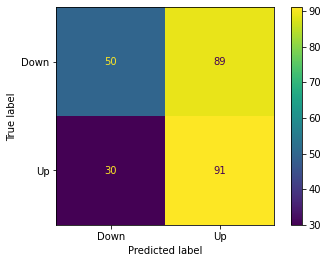

In [3]:
experiment_data = cp.Batch(start='2003-01-01',end='2014-12-31',currencies='USDEUR',filepath=filepath)
up_down = cp.Up_Down(experiment_data.log_ret,data_type='return')['USDEUR']
up_down['Up_Down'] = up_down['Up_Down'].shift(-1)
up_down.dropna(inplace=True)

train_data = up_down['2003-01-01':'2012-12-31']
X_train = train_data['close'].to_frame()
Y_train = train_data['Up_Down'].to_frame()

decision_tree = DecisionTreeClassifier(max_depth=5,min_samples_leaf=5,random_state=402811)
decision_tree.fit(X=X_train, y=Y_train)

test_data = up_down['2014-01-01':'2014-12-31']
X_test = test_data['close'].to_frame()
Y_test = test_data['Up_Down'].to_frame()

predict_classes = decision_tree.predict(X_test)
predict_probs = decision_tree.predict_proba(X_test)

print('Decision Tree Score: {}'.format(decision_tree.score(X=X_test, y=Y_test)))
print(classification_report(Y_test,predict_classes,zero_division=0))
confusion_data = confusion_matrix(Y_test,predict_classes,labels=decision_tree.classes_)
ConfusionMatrixDisplay(confusion_data, display_labels=decision_tree.classes_).plot()

Clearly we cannot predict whether the next day a currency will go up or down by only using the price from the day before using a decision tree. Our score for this experiment is close to 0.52, meaning this decision tree has 50/50 odds of getting a right answer. We need more data points that can help us better ascertain what could happen in the future

### Using lagged returns

Decision Tree Score: 0.4807692307692308
              precision    recall  f1-score   support

        Down       0.57      0.12      0.20       139
          Up       0.47      0.89      0.62       121

    accuracy                           0.48       260
   macro avg       0.52      0.51      0.41       260
weighted avg       0.52      0.48      0.39       260



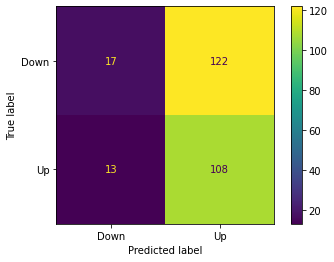

In [4]:
experiment_data = cp.Batch(start='2003-01-01',end='2014-12-31',currencies='USDEUR',filepath=filepath)

lag_ret_5d = cp.Lagged_Data(experiment_data.log_ret,lag_until=5)['USDEUR']
up_down = cp.Up_Down(experiment_data.log_ret,data_type='return')['USDEUR']
all_data = up_down.join(lag_ret_5d,rsuffix='_right')
all_data['Up_Down'] = all_data['Up_Down'].shift(-1)
all_data.drop('close_right',axis=1,inplace=True,errors='ignore')
all_data.dropna(inplace=True)

train_data = all_data['2003-01-01':'2012-12-31']
X_train = train_data.loc[:, train_data.columns != 'Up_Down']
Y_train = train_data.loc[:, 'Up_Down']

decision_tree = DecisionTreeClassifier(max_depth=7,min_samples_leaf=5,random_state=402811)
decision_tree.fit(X=X_train, y=Y_train)

test_data = all_data['2014-01-01':'2014-12-31']
X_test = test_data.loc[:, test_data.columns != 'Up_Down']
Y_test = test_data.loc[:, 'Up_Down']

predict_classes = decision_tree.predict(X_test)
predict_probs = decision_tree.predict_proba(X_test)

print('Decision Tree Score: {}'.format(decision_tree.score(X=X_test, y=Y_test)))
print(classification_report(Y_test,predict_classes,zero_division=0))
confusion_data = confusion_matrix(Y_test,predict_classes,labels=decision_tree.classes_)
ConfusionMatrixDisplay(confusion_data, display_labels=decision_tree.classes_).plot()


In this experiment using lagged returns for 5 days, we are using the return information of the last week to try to ascertain whether the next day will have a positive or negative return. However, as we can see above, there appears to be a strong bias for categorizing new data with an 'Up' label, this result in many correct predictions, but also we misclassify many observations that are supposed to be 'Down'. The results of this experiment are basically the same as the ones without lagged data.

### Using Indicators

In this case we will use ATR, Momentum, Moving Average, RSI, and RollingStDev

Decision Tree Score: 0.49230769230769234
              precision    recall  f1-score   support

        Down       0.58      0.18      0.27       139
          Up       0.47      0.85      0.61       121

    accuracy                           0.49       260
   macro avg       0.53      0.52      0.44       260
weighted avg       0.53      0.49      0.43       260



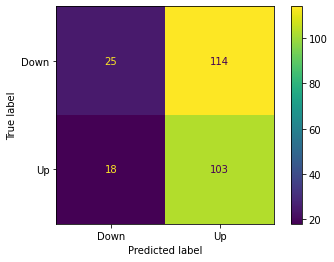

In [5]:
experiment_data = cp.Batch(start='2002-01-01',end='2014-12-31',currencies='USDEUR',filepath=filepath)

all_data = pd.DataFrame()
all_data['close'] = experiment_data.log_ret
all_data['Up_Down'] = cp.Up_Down(experiment_data.px_data,data_type='price')['USDEUR']['Up_Down'].shift(-1)
all_data['ATR'] = cp.ATR(experiment_data.px_data)['USDEUR']['ATR']
all_data['Momentum'] = cp.Momentum(experiment_data.px_data, period=20)['USDEUR']['Momentum']
all_data['50d_MA'] = cp.MA(experiment_data.px_data,period=50,ma_type='exponential')['USDEUR']['50d_MA']
all_data['200d_MA'] = cp.MA(experiment_data.px_data,period=200,ma_type='exponential')['USDEUR']['200d_MA']
all_data['RSI'] = cp.RSI(experiment_data.px_data)['USDEUR']['RSI']
all_data['StDev'] = cp.RollingStDev(experiment_data.px_data)['USDEUR']['StDev']
all_data.dropna(inplace=True)

train_data = all_data['2003-01-01':'2012-12-31']
X_train = train_data.loc[:, train_data.columns != 'Up_Down']
Y_train = train_data.loc[:, 'Up_Down']

decision_tree = DecisionTreeClassifier(max_depth=8,min_samples_leaf=5,random_state=402811)
decision_tree.fit(X=X_train, y=Y_train)

test_data = all_data['2014-01-01':'2014-12-31']
X_test = test_data.loc[:, test_data.columns != 'Up_Down']
Y_test = test_data.loc[:, 'Up_Down']

predict_classes = decision_tree.predict(X_test)
predict_probs = decision_tree.predict_proba(X_test)

print('Decision Tree Score: {}'.format(decision_tree.score(X=X_test, y=Y_test)))
print(classification_report(Y_test,predict_classes,zero_division=0))
confusion_data = confusion_matrix(Y_test,predict_classes,labels=decision_tree.classes_)
ConfusionMatrixDisplay(confusion_data, display_labels=decision_tree.classes_).plot()


In this experiment with indicators we can also see that the precision and recall improves only slightly when we add different data points based on the price. This could be because we are still relying on technicals that are based in the same data that we have seen until now. We can still observe a big bias towards the upside when it comes to inference, this is despite the fact that in both training and test data we can see an almost equal split between up and down days. I expect using random forests will eliminate this bias to some degree

### Interpreted Indicators

In this experiments we will interpret indicators to provide some context and abide by normal technical analysis rules. We will be using the following rules:

- Moving Average: Buy when the 50d_MA is over the 200d_MA. Sell when the 50d_MA is below the 200d_MA
- RSI: Buy when under 30. Sell when over 70. Otherwise do nothing
- Volatility: Buy when under the 15th percentile. Sell when over the 85th percentile. Otherwise do nothing
- MACD: Buy when the MACD is above the signal line. Sell when the MACD is below the signal line
- Momentum: Buy when over 100. Sell when under 100

Buy/Up : 1, Sell/Down : -1, Nothing: 0

Decision Tree Score: 0.5692307692307692
              precision    recall  f1-score   support

        Down       0.60      0.59      0.59       139
          Up       0.54      0.55      0.54       121

    accuracy                           0.57       260
   macro avg       0.57      0.57      0.57       260
weighted avg       0.57      0.57      0.57       260



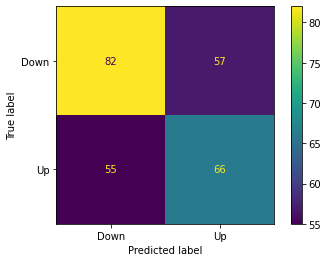

In [6]:
experiment_data = cp.Batch(start='2002-01-01',end='2014-12-31',currencies='USDEUR',filepath=filepath)

all_data = pd.DataFrame()
all_data['Momentum'] = cp.Momentum(experiment_data.px_data, period=20)['USDEUR']['Momentum']
all_data['50d_MA'] = cp.MA(experiment_data.px_data,period=50,ma_type='exponential')['USDEUR']['50d_MA']
all_data['200d_MA'] = cp.MA(experiment_data.px_data,period=200,ma_type='exponential')['USDEUR']['200d_MA']
all_data['RSI'] = cp.RSI(experiment_data.px_data)['USDEUR']['RSI']
all_data['StDev'] = cp.RollingStDev(experiment_data.px_data)['USDEUR']['StDev']

processed = pd.DataFrame()
processed['close'] = experiment_data.log_ret
processed['Up_Down'] = cp.Up_Down(experiment_data.px_data,data_type='price')['USDEUR']['Up_Down'].shift(-1)
processed['Momentum'] = all_data['Momentum'].apply(lambda x: 1 if x >= 100 else 0)
processed['RSI'] = all_data['RSI'].apply(lambda x: 1 if x < 30 else -1 if x > 70 else 0)
processed['Volatility'] = all_data['StDev'].apply(lambda x: 1 if x < np.percentile(all_data['StDev'].dropna(),20) else -1 if x > np.percentile(all_data['StDev'].dropna(),80) else 0)
processed['MA'] = np.where(all_data['50d_MA'] > all_data['200d_MA'], 1, -1)
processed['MACD'] = np.where(cp.MACD(experiment_data.px_data)['USDEUR']['macd'] > cp.MACD(experiment_data.px_data)['USDEUR']['signal_line'], 1, -1)
processed.dropna(inplace=True)

train_data = processed['2003-01-01':'2012-12-31']
X_train = train_data.loc[:, train_data.columns != 'Up_Down']
Y_train = train_data.loc[:, 'Up_Down']

decision_tree = DecisionTreeClassifier(max_depth=8,min_samples_leaf=5,random_state=402811)
decision_tree.fit(X=X_train, y=Y_train)

test_data = processed['2014-01-01':'2014-12-31']
X_test = test_data.loc[:, test_data.columns != 'Up_Down']
Y_test = test_data.loc[:, 'Up_Down']

predict_classes = decision_tree.predict(X_test)
predict_probs = decision_tree.predict_proba(X_test)

print('Decision Tree Score: {}'.format(decision_tree.score(X=X_test, y=Y_test)))
print(classification_report(Y_test,predict_classes,zero_division=0))
confusion_data = confusion_matrix(Y_test,predict_classes,labels=decision_tree.classes_)
ConfusionMatrixDisplay(confusion_data, display_labels=decision_tree.classes_).plot()

In this experiment the decision tree score and weighted average precision where almost similar to the ones we have obtained in the past when only using price or uninterpreted indicators. However, looking at the confusion matrix we can see that the bias that we had observed towards categorizing everything as going Up has shifted and a good number of observations is correctly labeled as going down. Nevertheless the scores haven't improved that much. Perhaps we can combine what we have used in the past with these new metrics to create more resilient forecasts.

### Indicators and Lagged Returns

Decision Tree Score: 0.4846153846153846
              precision    recall  f1-score   support

        Down       0.55      0.19      0.29       139
          Up       0.47      0.82      0.60       121

    accuracy                           0.48       260
   macro avg       0.51      0.51      0.44       260
weighted avg       0.51      0.48      0.43       260



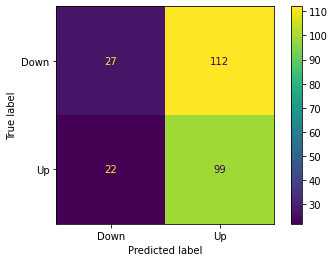

In [7]:
experiment_data = cp.Batch(start='2002-01-01',end='2014-12-31',currencies='USDEUR',filepath=filepath)

lag_ret_5d = cp.Lagged_Data(experiment_data.log_ret,lag_until=5)['USDEUR']
up_down = cp.Up_Down(experiment_data.log_ret,data_type='return')['USDEUR']
all_data = up_down.join(lag_ret_5d,rsuffix='_right')
all_data['Up_Down'] = all_data['Up_Down'].shift(-1)
all_data.drop('close_right',axis=1,inplace=True,errors='ignore')

all_data['ATR'] = cp.ATR(experiment_data.px_data)['USDEUR']['ATR']
all_data['Momentum'] = cp.Momentum(experiment_data.px_data, period=20)['USDEUR']['Momentum']
all_data['50d_MA'] = cp.MA(experiment_data.px_data,period=50,ma_type='exponential')['USDEUR']['50d_MA']
all_data['200d_MA'] = cp.MA(experiment_data.px_data,period=200,ma_type='exponential')['USDEUR']['200d_MA']
all_data['RSI'] = cp.RSI(experiment_data.px_data)['USDEUR']['RSI']
all_data['StDev'] = cp.RollingStDev(experiment_data.px_data)['USDEUR']['StDev']
all_data.dropna(inplace=True)

train_data = all_data['2003-01-01':'2012-12-31']
X_train = train_data.loc[:, train_data.columns != 'Up_Down']
Y_train = train_data.loc[:, 'Up_Down']

decision_tree = DecisionTreeClassifier(max_depth=10,min_samples_leaf=5,random_state=402811)
decision_tree.fit(X=X_train, y=Y_train)

test_data = all_data['2014-01-01':'2014-12-31']
X_test = test_data.loc[:, test_data.columns != 'Up_Down']
Y_test = test_data.loc[:, 'Up_Down']

predict_classes = decision_tree.predict(X_test)
predict_probs = decision_tree.predict_proba(X_test)

print('Decision Tree Score: {}'.format(decision_tree.score(X=X_test, y=Y_test)))
print(classification_report(Y_test,predict_classes,zero_division=0))
confusion_data = confusion_matrix(Y_test,predict_classes,labels=decision_tree.classes_)
ConfusionMatrixDisplay(confusion_data, display_labels=decision_tree.classes_).plot()


In this experiment we can see a slightly better precision score, however, the general decision tree score, as well as the weighted average precision/recall have not changed significantly. This is probably due to the fact that the confusion matrices in the previous experiments using only lagged returns or only uninterpreted technical indicators both showed a significant bias towards labeling a big number of observations as 'Up', this could have compounded when combining both datasets.

### Interpreted Indicators and Lagged Returns

Decision Tree Score: 0.49230769230769234
              precision    recall  f1-score   support

        Down       0.60      0.15      0.24       139
          Up       0.48      0.88      0.62       121

    accuracy                           0.49       260
   macro avg       0.54      0.52      0.43       260
weighted avg       0.54      0.49      0.42       260



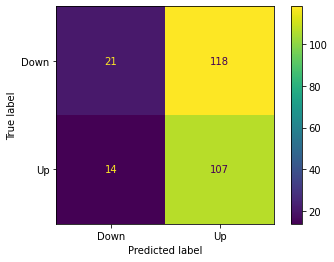

In [8]:
experiment_data = cp.Batch(start='2002-01-01',end='2014-12-31',currencies='USDEUR',filepath=filepath)

lag_ret_5d = cp.Lagged_Data(experiment_data.log_ret,lag_until=5)['USDEUR']
up_down = cp.Up_Down(experiment_data.log_ret,data_type='return')['USDEUR']
lagged = up_down.join(lag_ret_5d,rsuffix='_right')
lagged['Up_Down'] = lagged['Up_Down'].shift(-1)
lagged.drop('close_right',axis=1,inplace=True,errors='ignore')

all_data = pd.DataFrame()
all_data['Momentum'] = cp.Momentum(experiment_data.px_data, period=20)['USDEUR']['Momentum']
all_data['50d_MA'] = cp.MA(experiment_data.px_data,period=50,ma_type='exponential')['USDEUR']['50d_MA']
all_data['200d_MA'] = cp.MA(experiment_data.px_data,period=200,ma_type='exponential')['USDEUR']['200d_MA']
all_data['RSI'] = cp.RSI(experiment_data.px_data)['USDEUR']['RSI']
all_data['StDev'] = cp.RollingStDev(experiment_data.px_data)['USDEUR']['StDev']

processed = pd.DataFrame()
processed['Momentum'] = all_data['Momentum'].apply(lambda x: 1 if x >= 100 else 0)
processed['RSI'] = all_data['RSI'].apply(lambda x: 1 if x < 30 else -1 if x > 70 else 0)
processed['Volatility'] = all_data['StDev'].apply(lambda x: 1 if x < np.percentile(all_data['StDev'].dropna(),20) else -1 if x > np.percentile(all_data['StDev'].dropna(),80) else 0)
processed['MA'] = np.where(all_data['50d_MA'] > all_data['200d_MA'], 1, -1)
processed['MACD'] = np.where(cp.MACD(experiment_data.px_data)['USDEUR']['macd'] > cp.MACD(experiment_data.px_data)['USDEUR']['signal_line'], 1, -1)

final_df = lagged.join(processed)
final_df.dropna(inplace=True)

train_data = final_df['2003-01-01':'2012-12-31']
X_train = train_data.loc[:, train_data.columns != 'Up_Down']
Y_train = train_data.loc[:, 'Up_Down']

decision_tree = DecisionTreeClassifier(max_depth=10,min_samples_leaf=5,random_state=402811)
decision_tree.fit(X=X_train, y=Y_train)

test_data = final_df['2014-01-01':'2014-12-31']
X_test = test_data.loc[:, test_data.columns != 'Up_Down']
Y_test = test_data.loc[:, 'Up_Down']

predict_classes = decision_tree.predict(X_test)
predict_probs = decision_tree.predict_proba(X_test)

print('Decision Tree Score: {}'.format(decision_tree.score(X=X_test, y=Y_test)))
print(classification_report(Y_test,predict_classes,zero_division=0))
confusion_data = confusion_matrix(Y_test,predict_classes,labels=decision_tree.classes_)
ConfusionMatrixDisplay(confusion_data, display_labels=decision_tree.classes_).plot()

Sadly when combining lagged returns with interpreted technical indicators we still see that there is a significant bias towards labeling forecasts as 'Up', therefore we get a number of predictions right, but also a number of them are not correct. I expected more out of this experiment, however we might need another method, like for example Random Forests, to get rid of the inherent bias that is seen in the predictions

## Random Forests

In [2]:
param_grid = {'max_depth':[5, 8, 10, 14],
              'max_features':[2,4,6,8,12],
              'n_estimators':[25,50,100,200,300],
              'min_samples_split':[5,10,20,40],
              'random_state':[402811]}

## Classification

### Using Indicators

Fitting 4 folds for each of 400 candidates, totalling 1600 fits
Random Forest Score: 0.5384615384615384
              precision    recall  f1-score   support

        Down       0.70      0.24      0.35       139
          Up       0.50      0.88      0.64       121

    accuracy                           0.54       260
   macro avg       0.60      0.56      0.50       260
weighted avg       0.61      0.54      0.49       260



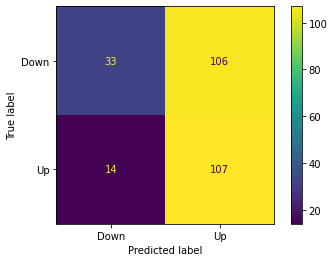

In [9]:
experiment_data = cp.Batch(start='2002-01-01',end='2014-12-31',currencies='USDEUR',filepath=filepath)

all_data = pd.DataFrame()
all_data['close'] = experiment_data.log_ret
all_data['Up_Down'] = cp.Up_Down(experiment_data.px_data,data_type='price')['USDEUR']['Up_Down'].shift(-1)
all_data['ATR'] = cp.ATR(experiment_data.px_data)['USDEUR']['ATR']
all_data['Momentum'] = cp.Momentum(experiment_data.px_data, period=20)['USDEUR']['Momentum']
all_data['50d_MA'] = cp.MA(experiment_data.px_data,period=50,ma_type='exponential')['USDEUR']['50d_MA']
all_data['200d_MA'] = cp.MA(experiment_data.px_data,period=200,ma_type='exponential')['USDEUR']['200d_MA']
all_data['RSI'] = cp.RSI(experiment_data.px_data)['USDEUR']['RSI']
all_data['StDev'] = cp.RollingStDev(experiment_data.px_data)['USDEUR']['StDev']
all_data.dropna(inplace=True)

train_data = all_data['2003-01-01':'2012-12-31']
X_train = train_data.loc[:, train_data.columns != 'Up_Down']
Y_train = train_data.loc[:, 'Up_Down']

tscv = TimeSeriesSplit(n_splits=4)
random_forest = RandomForestClassifier()
rf_Grid = GridSearchCV(random_forest, param_grid=param_grid, cv = tscv, scoring = 'roc_auc', refit = True, n_jobs=-1, verbose = 2, error_score=0.01)
rf_Grid.fit(X_train, Y_train)
cv_best_model = rf_Grid.best_estimator_

test_data = all_data['2014-01-01':'2014-12-31']
X_test = test_data.loc[:, test_data.columns != 'Up_Down']
Y_test = test_data.loc[:, 'Up_Down']

predict_classes = cv_best_model.predict(X_test)
predict_probs = cv_best_model.predict_proba(X_test)

print('Random Forest Score: {}'.format(cv_best_model.score(X=X_test, y=Y_test)))
print(classification_report(Y_test,predict_classes,zero_division=0))
confusion_data = confusion_matrix(Y_test,predict_classes,labels=cv_best_model.classes_)
ConfusionMatrixDisplay(confusion_data, display_labels=cv_best_model.classes_).plot()


Only using indicators the weighted average precision/recall scores actually have improved a bit, however this is not a big change from only using decision trees, there is still a big bias towards labeling predictions as 'Up'

### Using Interpreted Indicators

Fitting 4 folds for each of 400 candidates, totalling 1600 fits
Random Forest Score: 0.5423076923076923
              precision    recall  f1-score   support

        Down       0.58      0.53      0.55       139
          Up       0.51      0.55      0.53       121

    accuracy                           0.54       260
   macro avg       0.54      0.54      0.54       260
weighted avg       0.55      0.54      0.54       260



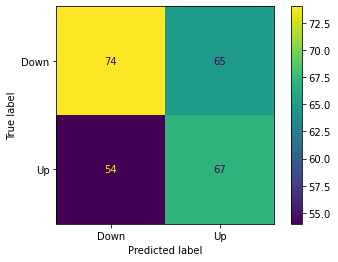

In [3]:
experiment_data = cp.Batch(start='2002-01-01',end='2014-12-31',currencies='USDEUR',filepath=filepath)

all_data = pd.DataFrame()
all_data['Momentum'] = cp.Momentum(experiment_data.px_data, period=20)['USDEUR']['Momentum']
all_data['50d_MA'] = cp.MA(experiment_data.px_data,period=50,ma_type='exponential')['USDEUR']['50d_MA']
all_data['200d_MA'] = cp.MA(experiment_data.px_data,period=200,ma_type='exponential')['USDEUR']['200d_MA']
all_data['RSI'] = cp.RSI(experiment_data.px_data)['USDEUR']['RSI']
all_data['StDev'] = cp.RollingStDev(experiment_data.px_data)['USDEUR']['StDev']

processed = pd.DataFrame()
processed['close'] = experiment_data.log_ret
processed['Up_Down'] = cp.Up_Down(experiment_data.px_data,data_type='price')['USDEUR']['Up_Down'].shift(-1)
processed['Momentum'] = all_data['Momentum'].apply(lambda x: 1 if x >= 100 else 0)
processed['RSI'] = all_data['RSI'].apply(lambda x: 1 if x < 30 else -1 if x > 70 else 0)
processed['Volatility'] = all_data['StDev'].apply(lambda x: 1 if x < np.percentile(all_data['StDev'].dropna(),20) else -1 if x > np.percentile(all_data['StDev'].dropna(),80) else 0)
processed['MA'] = np.where(all_data['50d_MA'] > all_data['200d_MA'], 1, -1)
processed['MACD'] = np.where(cp.MACD(experiment_data.px_data)['USDEUR']['macd'] > cp.MACD(experiment_data.px_data)['USDEUR']['signal_line'], 1, -1)
processed.dropna(inplace=True)

train_data = processed['2003-01-01':'2012-12-31']
X_train = train_data.loc[:, train_data.columns != 'Up_Down']
Y_train = train_data.loc[:, 'Up_Down']

tscv = TimeSeriesSplit(n_splits=4)
random_forest = RandomForestClassifier()
rf_Grid = GridSearchCV(random_forest, param_grid=param_grid, cv = tscv, scoring = 'roc_auc', refit = True, n_jobs=-1, verbose = 2, error_score=0.01)
rf_Grid.fit(X_train, Y_train)
cv_best_model = rf_Grid.best_estimator_

test_data = processed['2014-01-01':'2014-12-31']
X_test = test_data.loc[:, test_data.columns != 'Up_Down']
Y_test = test_data.loc[:, 'Up_Down']

predict_classes = cv_best_model.predict(X_test)
predict_probs = cv_best_model.predict_proba(X_test)

print('Random Forest Score: {}'.format(cv_best_model.score(X=X_test, y=Y_test)))
print(classification_report(Y_test,predict_classes,zero_division=0))
confusion_data = confusion_matrix(Y_test,predict_classes,labels=cv_best_model.classes_)
ConfusionMatrixDisplay(confusion_data, display_labels=cv_best_model.classes_).plot()

In this experiment we can see that interpreted indicators definitely have less of a bias than lagged returns or normal indicators. However, they are not necessatily better when it comes to precision/recall as other experiments. Still one of the best models we have seen until now

### Using Lagged Returns and Indicators

Fitting 4 folds for each of 400 candidates, totalling 1600 fits
Random Forest Score: 0.49230769230769234
              precision    recall  f1-score   support

        Down       0.61      0.14      0.22       139
          Up       0.48      0.90      0.62       121

    accuracy                           0.49       260
   macro avg       0.54      0.52      0.42       260
weighted avg       0.55      0.49      0.41       260



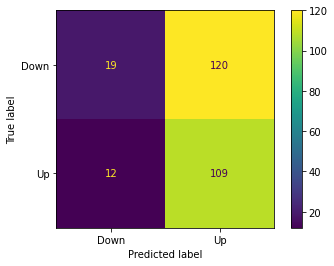

In [3]:
experiment_data = cp.Batch(start='2002-01-01',end='2014-12-31',currencies='USDEUR',filepath=filepath)

lag_ret_5d = cp.Lagged_Data(experiment_data.log_ret,lag_until=5)['USDEUR']
up_down = cp.Up_Down(experiment_data.log_ret,data_type='return')['USDEUR']
all_data = up_down.join(lag_ret_5d,rsuffix='_right')
all_data['Up_Down'] = all_data['Up_Down'].shift(-1)
all_data.drop('close_right',axis=1,inplace=True,errors='ignore')

all_data['ATR'] = cp.ATR(experiment_data.px_data)['USDEUR']['ATR']
all_data['Momentum'] = cp.Momentum(experiment_data.px_data, period=20)['USDEUR']['Momentum']
all_data['50d_MA'] = cp.MA(experiment_data.px_data,period=50,ma_type='exponential')['USDEUR']['50d_MA']
all_data['200d_MA'] = cp.MA(experiment_data.px_data,period=200,ma_type='exponential')['USDEUR']['200d_MA']
all_data['RSI'] = cp.RSI(experiment_data.px_data)['USDEUR']['RSI']
all_data['StDev'] = cp.RollingStDev(experiment_data.px_data)['USDEUR']['StDev']
all_data.dropna(inplace=True)

train_data = all_data['2003-01-01':'2012-12-31']
X_train = train_data.loc[:, train_data.columns != 'Up_Down']
Y_train = train_data.loc[:, 'Up_Down']

tscv = TimeSeriesSplit(n_splits=4)
random_forest = RandomForestClassifier()
rf_Grid = GridSearchCV(random_forest, param_grid=param_grid, cv = tscv, scoring = 'roc_auc', refit = True, n_jobs=-1, verbose = 2, error_score=0.01)
rf_Grid.fit(X_train, Y_train)
cv_best_model = rf_Grid.best_estimator_

test_data = all_data['2014-01-01':'2014-12-31']
X_test = test_data.loc[:, test_data.columns != 'Up_Down']
Y_test = test_data.loc[:, 'Up_Down']

predict_classes = cv_best_model.predict(X_test)
predict_probs = cv_best_model.predict_proba(X_test)

print('Random Forest Score: {}'.format(cv_best_model.score(X=X_test, y=Y_test)))
print(classification_report(Y_test,predict_classes,zero_division=0))
confusion_data = confusion_matrix(Y_test,predict_classes,labels=cv_best_model.classes_)
ConfusionMatrixDisplay(confusion_data, display_labels=cv_best_model.classes_).plot()

Slightly dissapointing that we weren't able to achieve higher results with a combination of lagged returns and indicators. However this was somewhat expected given that in the past both experiments have shown the same bias to the upside when using decision trees. Still even the best score of the grid search was surprisingly low considering what we have seen from other experiments

### Lagged Returns and Interpreted Indicators

Fitting 4 folds for each of 400 candidates, totalling 1600 fits
Random Forest Score: 0.5038461538461538
              precision    recall  f1-score   support

        Down       0.55      0.42      0.47       139
          Up       0.47      0.60      0.53       121

    accuracy                           0.50       260
   macro avg       0.51      0.51      0.50       260
weighted avg       0.51      0.50      0.50       260



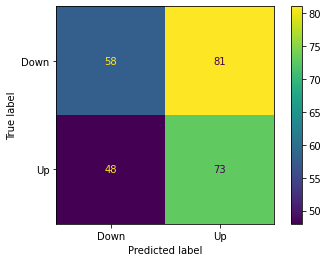

In [4]:
experiment_data = cp.Batch(start='2002-01-01',end='2014-12-31',currencies='USDEUR',filepath=filepath)

lag_ret_5d = cp.Lagged_Data(experiment_data.log_ret,lag_until=5)['USDEUR']
up_down = cp.Up_Down(experiment_data.log_ret,data_type='return')['USDEUR']
lagged = up_down.join(lag_ret_5d,rsuffix='_right')
lagged['Up_Down'] = lagged['Up_Down'].shift(-1)
lagged.drop('close_right',axis=1,inplace=True,errors='ignore')

all_data = pd.DataFrame()
all_data['Momentum'] = cp.Momentum(experiment_data.px_data, period=20)['USDEUR']['Momentum']
all_data['50d_MA'] = cp.MA(experiment_data.px_data,period=50,ma_type='exponential')['USDEUR']['50d_MA']
all_data['200d_MA'] = cp.MA(experiment_data.px_data,period=200,ma_type='exponential')['USDEUR']['200d_MA']
all_data['RSI'] = cp.RSI(experiment_data.px_data)['USDEUR']['RSI']
all_data['StDev'] = cp.RollingStDev(experiment_data.px_data)['USDEUR']['StDev']

processed = pd.DataFrame()
processed['Momentum'] = all_data['Momentum'].apply(lambda x: 1 if x >= 100 else 0)
processed['RSI'] = all_data['RSI'].apply(lambda x: 1 if x < 30 else -1 if x > 70 else 0)
processed['Volatility'] = all_data['StDev'].apply(lambda x: 1 if x < np.percentile(all_data['StDev'].dropna(),20) else -1 if x > np.percentile(all_data['StDev'].dropna(),80) else 0)
processed['MA'] = np.where(all_data['50d_MA'] > all_data['200d_MA'], 1, -1)
processed['MACD'] = np.where(cp.MACD(experiment_data.px_data)['USDEUR']['macd'] > cp.MACD(experiment_data.px_data)['USDEUR']['signal_line'], 1, -1)

final_df = lagged.join(processed)
final_df.dropna(inplace=True)

train_data = final_df['2003-01-01':'2012-12-31']
X_train = train_data.loc[:, train_data.columns != 'Up_Down']
Y_train = train_data.loc[:, 'Up_Down']

tscv = TimeSeriesSplit(n_splits=4)
random_forest = RandomForestClassifier()
rf_Grid = GridSearchCV(random_forest, param_grid=param_grid, cv = tscv, scoring = 'roc_auc', refit = True, n_jobs=-1, verbose = 2, error_score=0.01)
rf_Grid.fit(X_train, Y_train)
cv_best_model = rf_Grid.best_estimator_

test_data = final_df['2014-01-01':'2014-12-31']
X_test = test_data.loc[:, test_data.columns != 'Up_Down']
Y_test = test_data.loc[:, 'Up_Down']

predict_classes = cv_best_model.predict(X_test)
predict_probs = cv_best_model.predict_proba(X_test)

print('Random Forest Score: {}'.format(cv_best_model.score(X=X_test, y=Y_test)))
print(classification_report(Y_test,predict_classes,zero_division=0))
confusion_data = confusion_matrix(Y_test,predict_classes,labels=cv_best_model.classes_)
ConfusionMatrixDisplay(confusion_data, display_labels=cv_best_model.classes_).plot()

Slightly dissapointing that we haven't been able to raise the classifier score above 0.54, and in this case only 0.50. However, in this experiment we can see that there is less of a bias towards the upside which we have seen in the past from interpreted indicators. Either because this is a new type of data or perhaps they are less correlated to price data, in general I believe these models could do well. I would like to adjust the threshold for selecting a class to see how the confusion matrix changes